In [1]:
%pip install -q dagshub mlflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import dagshub
dagshub.init(repo_owner='yaseensiddiqui36', repo_name='my-first-repo', mlflow=True)

Accessing as yaseensiddiqui36

Initialized MLflow to track repo "yaseensiddiqui36/my-first-repo"

Repository yaseensiddiqui36/my-first-repo initialized!

In [3]:
import pandas as pd
import numpy as np
import sqlite3
from sqlite3 import Error

C:\Users\Yaseen\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

In [5]:
def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [6]:
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [7]:
db_name = 'equipment_anamoly_data.db'

In [8]:
conn = create_connection(db_name)

In [9]:
conn

In [10]:
df = pd.read_csv('equipment_anomaly_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'equipment_anomaly_data.csv'

In [11]:
df

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0
...,...,...,...,...,...,...,...
7667,65.711521,37.505934,2.030521,49.331471,Pump,New York,0.0
7668,63.005855,45.164234,1.264585,61.905390,Pump,New York,0.0
7669,72.029230,34.757896,1.709046,49.972917,Pump,Atlanta,0.0
7670,107.086485,23.754114,1.142522,23.967977,Compressor,Atlanta,1.0


### Creating the tables in the database following the 3NF form

#### We will create 3 tables:

### Newly created Normalized Database in 3NF form with tables Location, Equipment, Measurements

In [12]:
import sqlite3
import csv

# Database file name
db_name = "equipment_anamoly_data.db"

# Connect to the database
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

# Drop tables if they exist
cursor.execute("DROP TABLE IF EXISTS Measurements")
cursor.execute("DROP TABLE IF EXISTS Equipment")
cursor.execute("DROP TABLE IF EXISTS Location")

# Create Location table
cursor.execute("""
CREATE TABLE Location (
    location_id INTEGER PRIMARY KEY AUTOINCREMENT,
    location_name TEXT UNIQUE
)
""")

# Create Equipment table
cursor.execute("""
CREATE TABLE Equipment (
    equipment_id INTEGER PRIMARY KEY AUTOINCREMENT,
    equipment_name TEXT UNIQUE
)
""")

# Create Measurements table
cursor.execute("""
CREATE TABLE Measurements (
    measurement_id INTEGER PRIMARY KEY AUTOINCREMENT,
    equipment_id INTEGER,
    location_id INTEGER,
    temperature REAL,
    pressure REAL,
    vibration REAL,
    humidity REAL,
    faulty INTEGER,
    FOREIGN KEY (equipment_id) REFERENCES Equipment(equipment_id),
    FOREIGN KEY (location_id) REFERENCES Location(location_id)
)
""")

# Commit changes
conn.commit()
print("Database and tables recreated.")


Database and tables recreated.


In [13]:
# Read unique locations and equipment from the CSV file
location_set = set()
equipment_set = set()

with open("equipment_anomaly_data.csv", "r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        location_set.add(row["location"])
        equipment_set.add(row["equipment"])

# Convert sets to sorted lists for consistency
unique_locations = sorted(location_set)
unique_equipments = sorted(equipment_set)

# Populate Location table
location_dict = {}
for location in unique_locations:
    cursor.execute("INSERT INTO Location (location_name) VALUES (?)", (location,))
    location_dict[location] = cursor.lastrowid

# Populate Equipment table
equipment_dict = {}
for equipment in unique_equipments:
    cursor.execute("INSERT INTO Equipment (equipment_name) VALUES (?)", (equipment,))
    equipment_dict[equipment] = cursor.lastrowid

# Commit changes
conn.commit()
print("Location and Equipment tables populated.")


Location and Equipment tables populated.


In [14]:
# Read data from the CSV file and populate the Measurements table
with open("equipment_anomaly_data.csv", "r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        equipment_id = equipment_dict[row["equipment"]]
        location_id = location_dict[row["location"]]
        temperature = float(row["temperature"])
        pressure = float(row["pressure"])
        vibration = float(row["vibration"])
        humidity = float(row["humidity"])
        faulty = int(float(row["faulty"]))  # Convert faulty to integer
        
        cursor.execute("""
        INSERT INTO Measurements (equipment_id, location_id, temperature, pressure, vibration, humidity, faulty)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (equipment_id, location_id, temperature, pressure, vibration, humidity, faulty))

# Commit changes and close the connection
conn.commit()
conn.close()

print("Measurements table populated.")


Measurements table populated.


#### Newly created Normalized Database in 3NF form with tables Location, Equipment, Measurements

In [15]:
import pandas as pd

# Reconnect to the database
conn = sqlite3.connect(db_name)

# Display table contents
def display_table(table_name):
    print(f"Contents of table {table_name}:")
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    print(df)
    print()

# Show contents of each table
display_table("Location")
display_table("Equipment")
display_table("Measurements")

# Close the connection
conn.close()


Contents of table Location:
   location_id  location_name
0            1        Atlanta
1            2        Chicago
2            3        Houston
3            4       New York
4            5  San Francisco

Contents of table Equipment:
   equipment_id equipment_name
0             1     Compressor
1             2           Pump
2             3        Turbine

Contents of table Measurements:
      measurement_id  equipment_id  location_id  temperature   pressure  \
0                  1             3            1    58.180180  25.029278   
1                  2             1            2    75.740712  22.954018   
2                  3             3            5    71.358594  27.276830   
3                  4             2            1    71.616985  32.242921   
4                  5             2            4    66.506832  45.197471   
...              ...           ...          ...          ...        ...   
7667            7668             2            4    65.711521  37.505934   
7668 

In [16]:
# Connect to the database
conn = sqlite3.connect(db_name)

# SQL query to fetch normalized data
query = """
SELECT
    Equipment.equipment_name,
    Location.location_name,
    Measurements.temperature,
    Measurements.pressure,
    Measurements.vibration,
    Measurements.humidity,
    Measurements.faulty
FROM 
    Measurements
JOIN 
    Equipment ON Measurements.equipment_id = Equipment.equipment_id
JOIN 
    Location ON Measurements.location_id = Location.location_id;
"""

# Execute the query and load data into a pandas DataFrame
df1 = pd.read_sql_query(query, conn)

# Display the DataFrame
print(df1)

# Close the connection
conn.close()


     equipment_name  location_name  temperature   pressure  vibration  \
0           Turbine        Atlanta    58.180180  25.029278   0.606516   
1        Compressor        Chicago    75.740712  22.954018   2.338095   
2           Turbine  San Francisco    71.358594  27.276830   1.389198   
3              Pump        Atlanta    71.616985  32.242921   1.770690   
4              Pump       New York    66.506832  45.197471   0.345398   
...             ...            ...          ...        ...        ...   
7667           Pump       New York    65.711521  37.505934   2.030521   
7668           Pump       New York    63.005855  45.164234   1.264585   
7669           Pump        Atlanta    72.029230  34.757896   1.709046   
7670     Compressor        Atlanta   107.086485  23.754114   1.142522   
7671        Turbine        Chicago    28.468054  66.588978   4.677368   

       humidity  faulty  
0     45.694907       0  
1     41.867407       0  
2     58.954409       0  
3     40.565138    

In [17]:
df1

,equipment_name,location_name,temperature,pressure,vibration,humidity,faulty
0,Turbine,Atlanta,58.180180,25.029278,0.606516,45.694907,0
1,Compressor,Chicago,75.740712,22.954018,2.338095,41.867407,0
2,Turbine,San Francisco,71.358594,27.276830,1.389198,58.954409,0
3,Pump,Atlanta,71.616985,32.242921,1.770690,40.565138,0
4,Pump,New York,66.506832,45.197471,0.345398,43.253795,0
...,...,...,...,...,...,...,...
7667,Pump,New York,65.711521,37.505934,2.030521,49.331471,0
7668,Pump,New York,63.005855,45.164234,1.264585,61.905390,0
7669,Pump,Atlanta,72.029230,34.757896,1.709046,49.972917,0
7670,Compressor,Atlanta,107.086485,23.754114,1.142522,23.967977,1


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

faulty
0    0.900026
1    0.099974
Name: proportion, dtype: float64


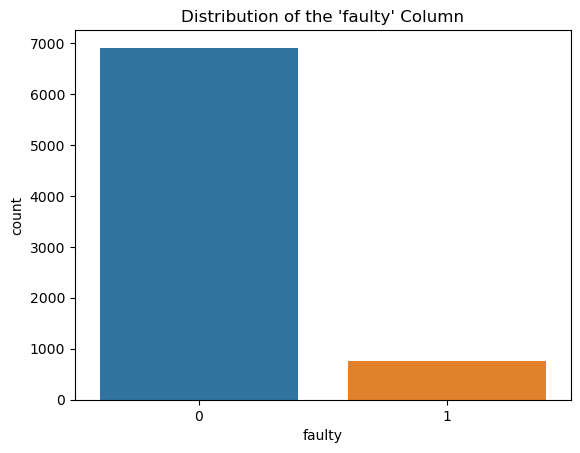

In [19]:
# Check distribution of the target variable
print(df1["faulty"].value_counts(normalize=True))

# Visualize the target distribution
sns.countplot(data=df1, x="faulty")
plt.title("Distribution of the 'faulty' Column")
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

# Features and target
X = df1.drop(columns=["faulty"])
y = df1["faulty"]

# Perform train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify stratification
print("Train set distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))


Train set distribution:
faulty
0    0.899951
1    0.100049
Name: proportion, dtype: float64

Test set distribution:
faulty
0    0.900326
1    0.099674
Name: proportion, dtype: float64


equipment_name
Compressor    0.335375
Turbine       0.334333
Pump          0.330292
Name: proportion, dtype: float64


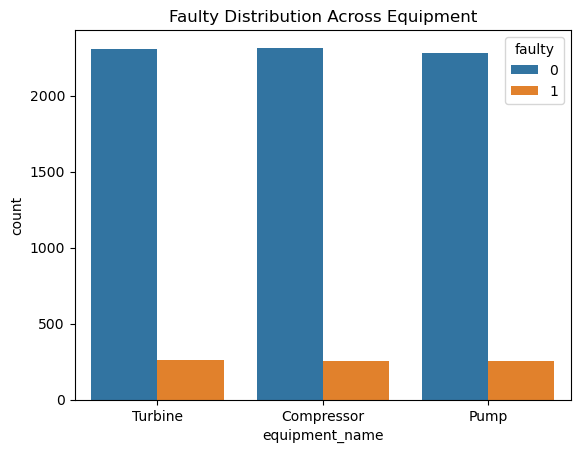

In [21]:
print(df1["equipment_name"].value_counts(normalize=True))

# Visualize distribution by equipment
sns.countplot(data=df1, x="equipment_name", hue="faulty")
plt.title("Faulty Distribution Across Equipment")
plt.show()

location_name
Atlanta          0.203858
Chicago          0.202424
Houston          0.201773
New York         0.198905
San Francisco    0.193040
Name: proportion, dtype: float64


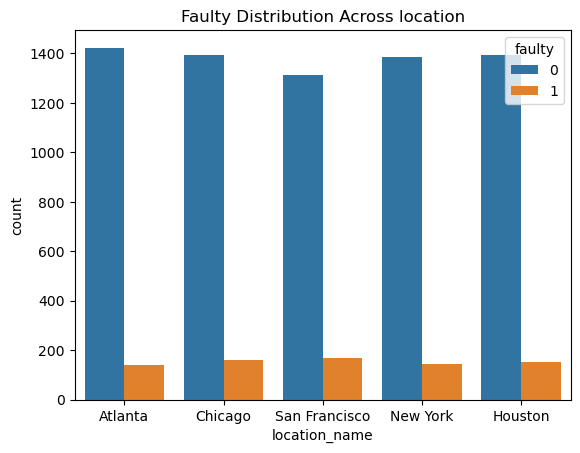

In [22]:
print(df1["location_name"].value_counts(normalize=True))

# Visualize distribution by equipment
sns.countplot(data=df1, x="location_name", hue="faulty")
plt.title("Faulty Distribution Across location")
plt.show()

In [23]:
print("Train set distribution:")
print(y_train.value_counts(normalize=True))

print("\n\nTest set distribution:")
print(y_test.value_counts(normalize=True))

Train set distribution:
faulty
0    0.899951
1    0.100049
Name: proportion, dtype: float64


Test set distribution:
faulty
0    0.900326
1    0.099674
Name: proportion, dtype: float64


In [24]:
# Basic summary statistics
df1.describe()

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574,0.099974
std,16.200059,10.381593,0.728560,11.841479,0.299985
min,10.269385,3.620798,-0.428188,10.215077,0.000000
25%,62.777057,29.485682,1.170906,42.612817,0.000000
50%,70.156900,35.227544,1.533113,50.024744,0.000000
75%,77.568387,41.159913,1.924700,57.340513,0.000000
max,149.690420,79.887734,4.990537,89.984718,1.000000


In [25]:
# Data types of the columns
df1.dtypes



equipment_name     object
location_name      object
temperature       float64
pressure          float64
vibration         float64
humidity          float64
faulty              int64
dtype: object

In [26]:
# Checking for missing values
df1.isnull().sum()

equipment_name    0
location_name     0
temperature       0
pressure          0
vibration         0
humidity          0
faulty            0
dtype: int64

In [27]:
# Checking the unique values in categorical columns
df1["equipment_name"].value_counts()

equipment_name
Compressor    2573
Turbine       2565
Pump          2534
Name: count, dtype: int64

In [28]:
df1["location_name"].value_counts()

location_name
Atlanta          1564
Chicago          1553
Houston          1548
New York         1526
San Francisco    1481
Name: count, dtype: int64

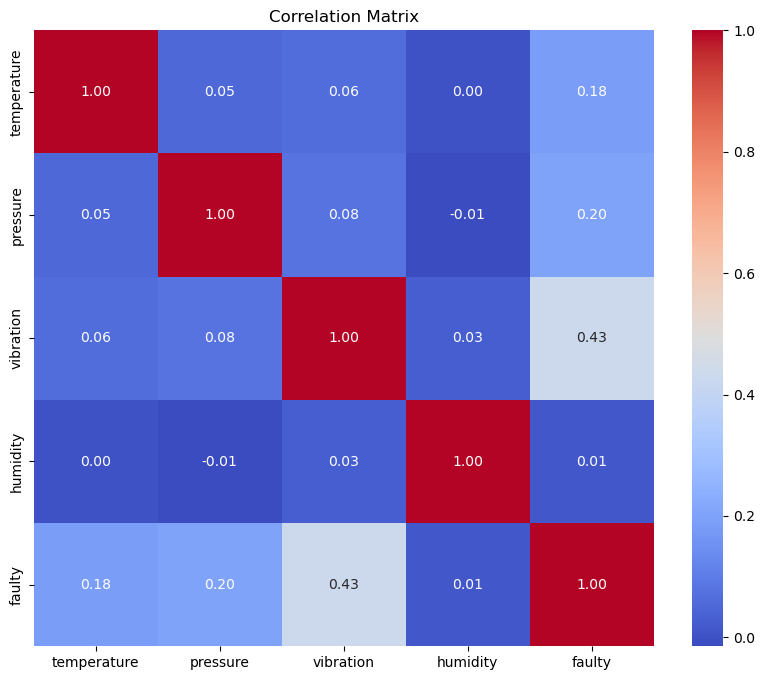

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Plotting a correlation matrix heatmap
# correlation_matrix = df.corr()

correlation_matrix = df1[['temperature', 'pressure','vibration','humidity','faulty']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


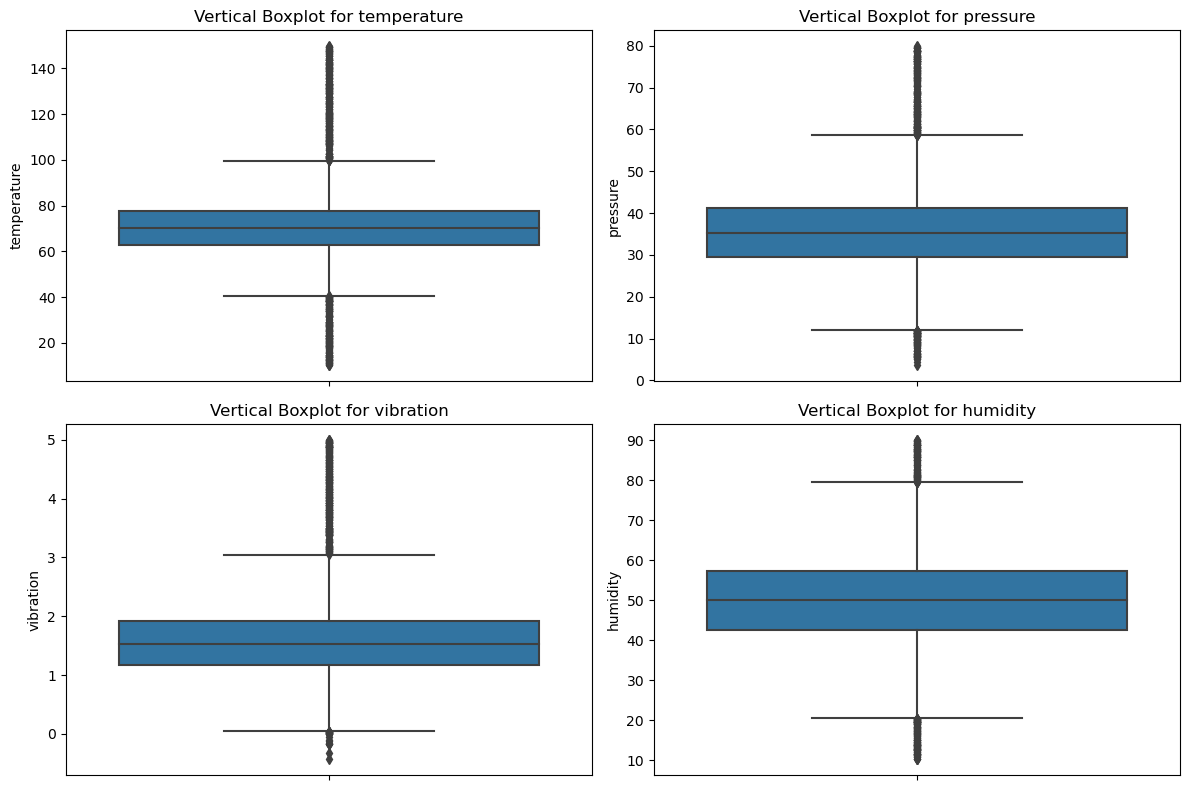

In [30]:
numerical_cols = ["temperature", "pressure", "vibration", "humidity"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Loop through each numerical column and plot it on a subplot
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df1[col], ax=axes[i])  # Plot on the ith subplot
    axes[i].set_title(f"Vertical Boxplot for {col}")

plt.tight_layout()
plt.show()

C:\Users\Yaseen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yaseen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Yaseen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Yaseen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option

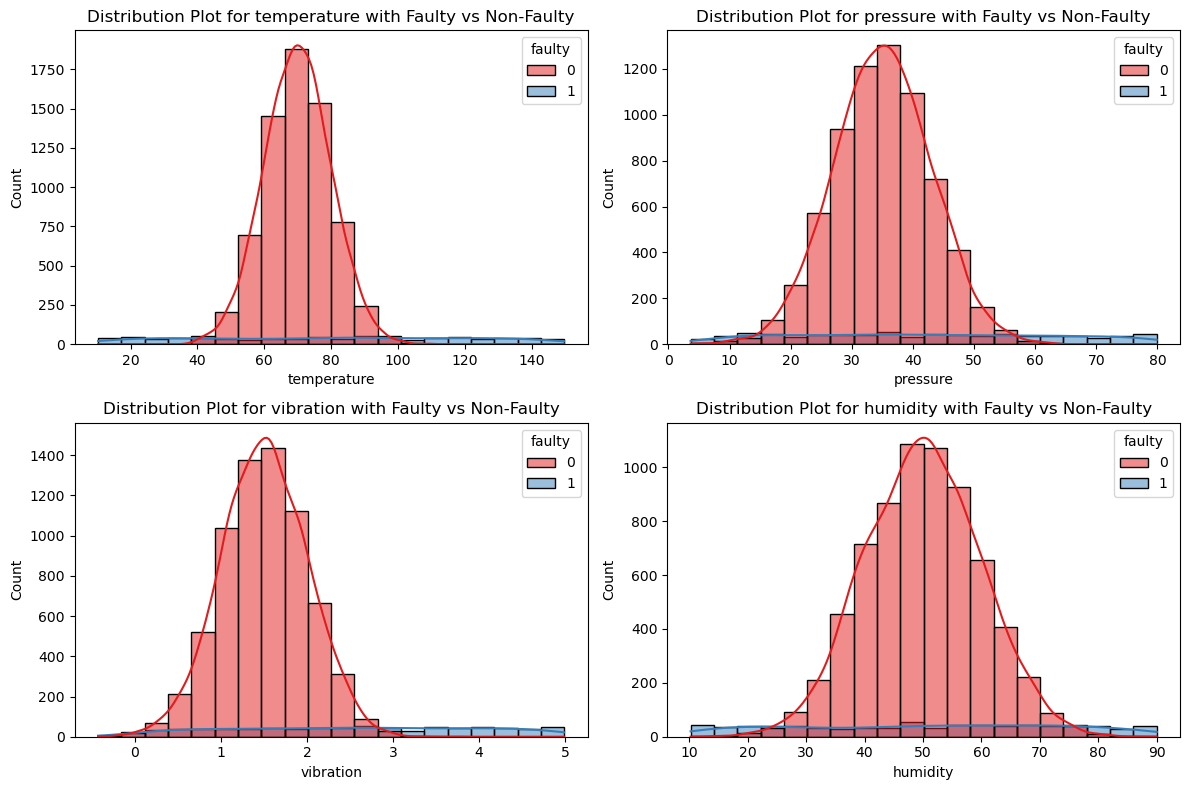

In [31]:
# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numerical column and create distribution plots with 'hue' for 'faulty'
for i, col in enumerate(numerical_cols):
    sns.histplot(df1, x=col, hue="faulty", kde=True, bins=20, ax=axes[i], palette="Set1")  # kde=True adds Kernel Density Estimation
    axes[i].set_title(f"Distribution Plot for {col} with Faulty vs Non-Faulty")
    
# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [32]:
df1.head()

,equipment_name,location_name,temperature,pressure,vibration,humidity,faulty
0,Turbine,Atlanta,58.180180,25.029278,0.606516,45.694907,0
1,Compressor,Chicago,75.740712,22.954018,2.338095,41.867407,0
2,Turbine,San Francisco,71.358594,27.276830,1.389198,58.954409,0
3,Pump,Atlanta,71.616985,32.242921,1.770690,40.565138,0
4,Pump,New York,66.506832,45.197471,0.345398,43.253795,0


C:\Users\Yaseen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yaseen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yaseen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yaseen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

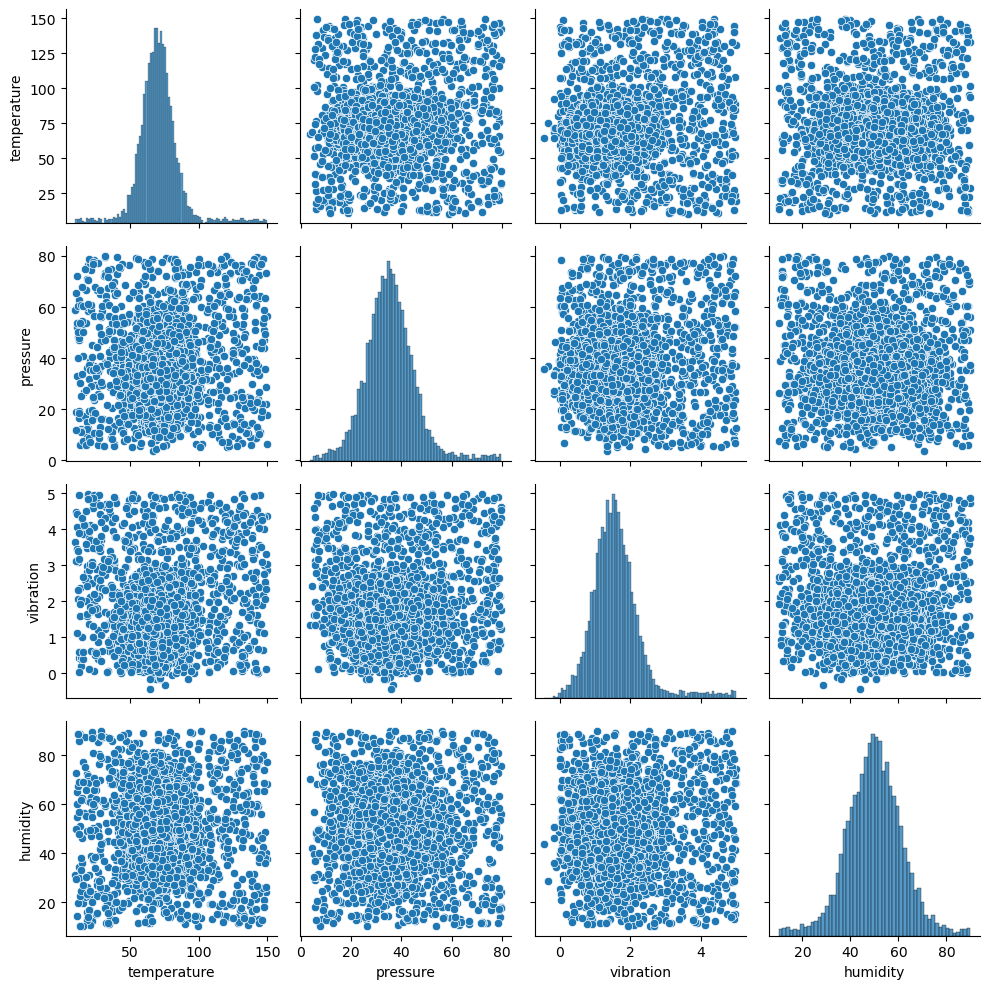

In [33]:
# Create a pair plot of all the features in the dataframe
sns.pairplot(df1[['temperature', 'pressure', 'vibration', 'humidity']])

# Display the plot
plt.tight_layout()
plt.show()

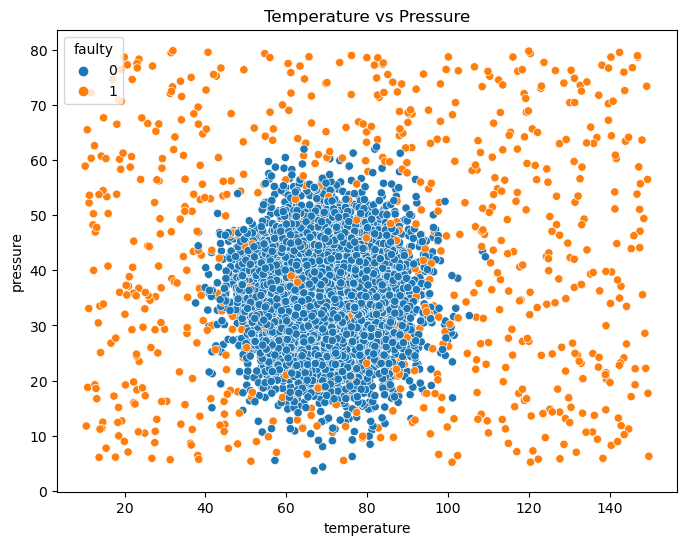

In [34]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df1, x='temperature', y='pressure', hue='faulty')

# Set the plot title
plt.title("Temperature vs Pressure")

# Display the plot
plt.show()

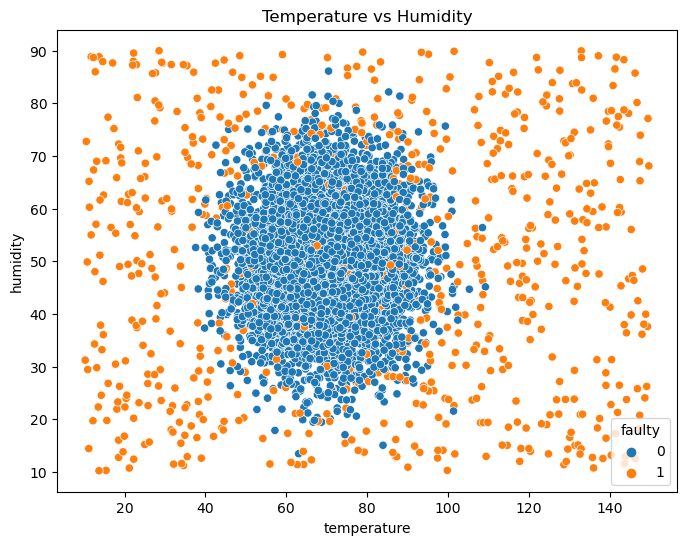

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df1, x='temperature', y='humidity', hue='faulty')

# Set the plot title
plt.title("Temperature vs Humidity")

# Display the plot
plt.show()

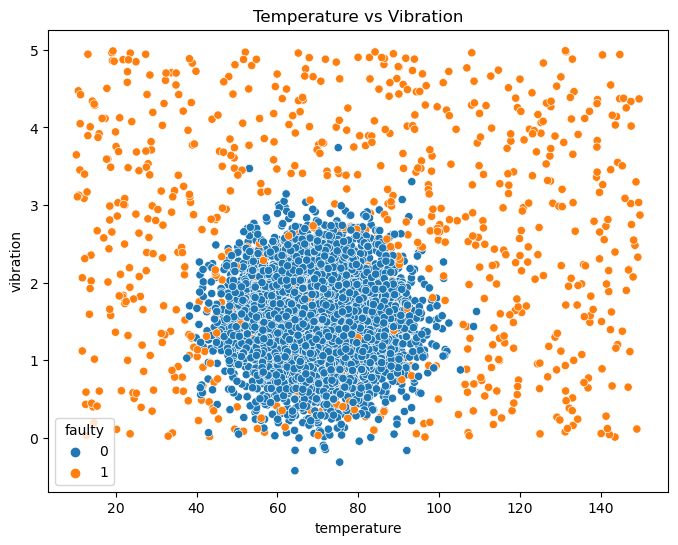

In [36]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df1, x='temperature', y='vibration', hue='faulty')

# Set the plot title
plt.title("Temperature vs Vibration")

# Display the plot
plt.show()

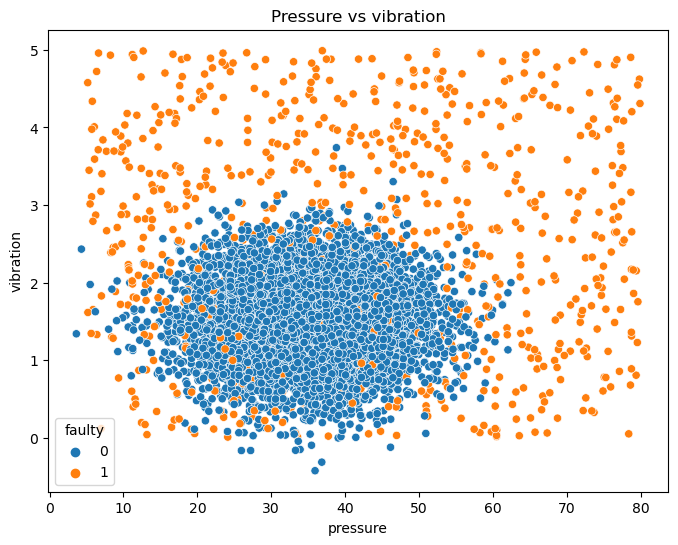

In [37]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df1, x='pressure', y='vibration', hue='faulty')

# Set the plot title
plt.title("Pressure vs vibration")

# Display the plot
plt.show()

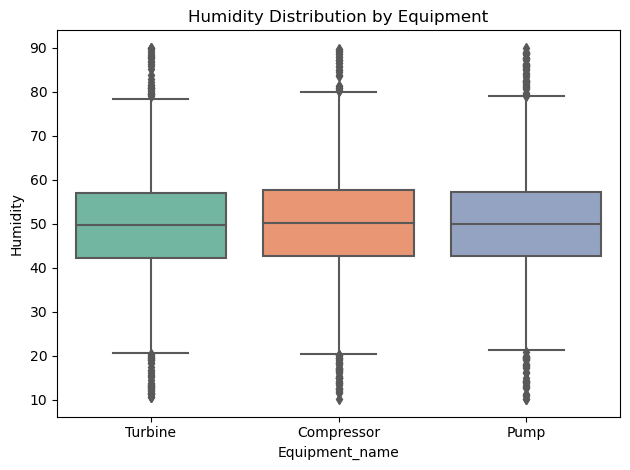

In [38]:
# Create the box plot
sns.boxplot(x='equipment_name', y='humidity', data=df1, palette='Set2')

# Set plot title and labels
plt.title('Humidity Distribution by Equipment')
plt.xlabel('Equipment_name')
plt.ylabel('Humidity')

# Display the plot
plt.tight_layout()
plt.show()

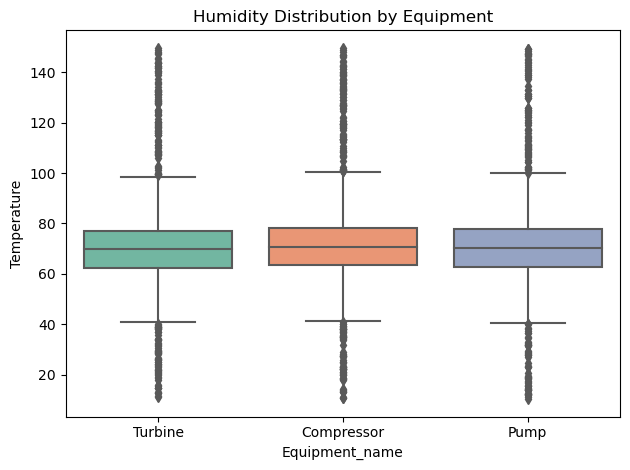

In [39]:
# Create the box plot
sns.boxplot(x='equipment_name', y='temperature', data=df1, palette='Set2')

# Set plot title and labels
plt.title('Humidity Distribution by Equipment')
plt.xlabel('Equipment_name')
plt.ylabel('Temperature')

# Display the plot
plt.tight_layout()
plt.show()

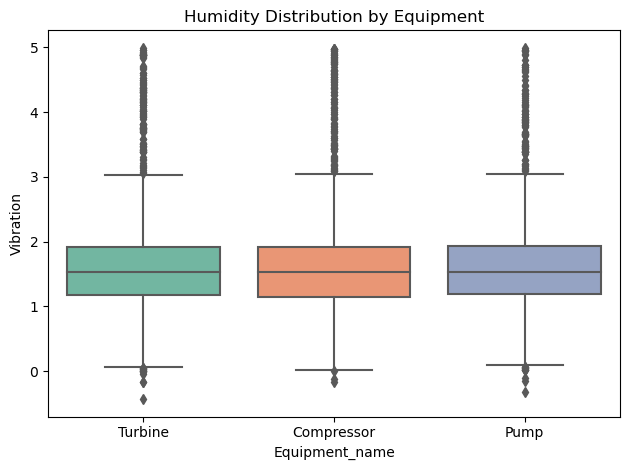

In [40]:
# Create the box plot
sns.boxplot(x='equipment_name', y='vibration', data=df1, palette='Set2')

# Set plot title and labels
plt.title('Humidity Distribution by Equipment')
plt.xlabel('Equipment_name')
plt.ylabel('Vibration')

# Display the plot
plt.tight_layout()
plt.show()

### Preprocessing

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
import mlflow.sklearn

In [42]:
X = df1.drop(columns=['faulty'])  # Replace with your actual target column name
y = df1['faulty']  # Replace with your actual target column name

In [43]:
df1

,equipment_name,location_name,temperature,pressure,vibration,humidity,faulty
0,Turbine,Atlanta,58.180180,25.029278,0.606516,45.694907,0
1,Compressor,Chicago,75.740712,22.954018,2.338095,41.867407,0
2,Turbine,San Francisco,71.358594,27.276830,1.389198,58.954409,0
3,Pump,Atlanta,71.616985,32.242921,1.770690,40.565138,0
4,Pump,New York,66.506832,45.197471,0.345398,43.253795,0
...,...,...,...,...,...,...,...
7667,Pump,New York,65.711521,37.505934,2.030521,49.331471,0
7668,Pump,New York,63.005855,45.164234,1.264585,61.905390,0
7669,Pump,Atlanta,72.029230,34.757896,1.709046,49.972917,0
7670,Compressor,Atlanta,107.086485,23.754114,1.142522,23.967977,1


In [44]:
X

,equipment_name,location_name,temperature,pressure,vibration,humidity
0,Turbine,Atlanta,58.180180,25.029278,0.606516,45.694907
1,Compressor,Chicago,75.740712,22.954018,2.338095,41.867407
2,Turbine,San Francisco,71.358594,27.276830,1.389198,58.954409
3,Pump,Atlanta,71.616985,32.242921,1.770690,40.565138
4,Pump,New York,66.506832,45.197471,0.345398,43.253795
...,...,...,...,...,...,...
7667,Pump,New York,65.711521,37.505934,2.030521,49.331471
7668,Pump,New York,63.005855,45.164234,1.264585,61.905390
7669,Pump,Atlanta,72.029230,34.757896,1.709046,49.972917
7670,Compressor,Atlanta,107.086485,23.754114,1.142522,23.967977


In [45]:
y

0       0
1       0
2       0
3       0
4       0
       ..
7667    0
7668    0
7669    0
7670    1
7671    1
Name: faulty, Length: 7672, dtype: int64

In [46]:
# Define numerical and categorical columns
numerical_features = ['temperature', 'pressure', 'vibration', 'humidity']  # Replace with your actual numerical features
categorical_features = ['equipment_name', 'location_name']  # Replace with your actual categorical features

In [47]:
# Define the preprocessor pipeline for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler()),  # Standardize the data
    ('minmax', MinMaxScaler())  # Min-Max scaling (if required, can be adjusted)
])

In [48]:
# Define the preprocessor pipeline for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [51]:
# Create the complete pipeline with preprocessor and Logistic Regression
pipeline_logistic_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())  # Logistic Regression model
])

In [70]:
# Perform Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Logistic Regression

In [53]:
mlflow.sklearn.autolog()


# Start an MLflow run and fit the pipeline
with mlflow.start_run():
    # Fit the model
    pipeline_logistic_regression.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline_logistic_regression.predict(X_test)

    # Evaluate the model and log metrics
    print("Confusion Matrix on Test Data:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report on Test Data:\n", classification_report(y_test, y_pred))

Confusion Matrix on Test Data:
 [[1381    1]
 [  93   60]]

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1382
           1       0.98      0.39      0.56       153

    accuracy                           0.94      1535
   macro avg       0.96      0.70      0.76      1535
weighted avg       0.94      0.94      0.93      1535

🏃 View run magnificent-bass-171 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/f26deb77bd5a4ff3aad907fee9c9bfcd
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


In [54]:
# Enable autologging for scikit-learn
mlflow.sklearn.autolog()

# Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# Create the pipeline with preprocessing and logistic regression
pipeline_logistic_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Hyperparameter grid for Logistic Regression (for example, C and solver)
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']  # Solver options for logistic regression
}

# Perform GridSearchCV for hyperparameter tuning with 10-fold cross-validation
grid_search = GridSearchCV(pipeline_logistic_regression, param_grid, cv=10, n_jobs=1)  # Use n_jobs=1 to avoid parallel execution

# Start an MLflow run
with mlflow.start_run():
    # Fit the model on the entire training set with hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Log the best hyperparameters and score
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric('best_score', grid_search.best_score_)

    # Evaluate the model and log metrics
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Best Cross-Validation Score: {grid_search.best_score_}")

    # Cross-validation results: mean and standard deviation
    cv_results = grid_search.cv_results_
    mean_score = np.mean(cv_results['mean_test_score'])
    std_score = np.std(cv_results['mean_test_score'])
    print(f"CV Mean Score: {mean_score:.4f}, CV Std Score: {std_score:.4f}")

    # Evaluate the model performance on the entire training data
    y_train_pred = grid_search.predict(X_train)
    print("\nTraining Data Classification Report:\n", classification_report(y_train, y_train_pred))

    # Evaluate the model performance on the test data
    y_test_pred = grid_search.predict(X_test)
    print("\nTest Data Classification Report:\n", classification_report(y_test, y_test_pred))

    # Log the classification reports for training and test data
    mlflow.log_metric('train_accuracy', grid_search.score(X_train, y_train))
    mlflow.log_metric('test_accuracy', grid_search.score(X_test, y_test))

    # Confusion matrix for the test data
    print("\nConfusion Matrix on Test Data:\n", confusion_matrix(y_test, y_test_pred))


C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

🏃 View run incongruous-doe-550 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/2662af8b918b4380b8b7a33dd0dcd7ce
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run omniscient-chimp-293 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/8590b0251e5747b2b2f4d8e8a2c17bf6
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run inquisitive-gull-113 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/95c3436edccd46e0813ed1bf4bf40358
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run resilient-sow-137 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/4583d86cecae489287a6b0ae8310eb22
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run rebellious-cat-30

In [55]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb

In [56]:
# Enable autologging for scikit-learn
mlflow.sklearn.autolog()

# Define classifiers to test
classifiers = {
    'RidgeClassifier': RidgeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': xgb.XGBClassifier(eval_metric='logloss')
}

# Hyperparameter grid for each classifier
param_grids = {
    'RidgeClassifier': {
        'classifier__alpha': [0.1, 1.0, 10.0]
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [10, 20, None]
    },
    'XGBClassifier': {
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__n_estimators': [50, 100]
    }
}

# Iterate over each classifier
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name}...")
    
    # Create the pipeline with preprocessing and the classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Get the corresponding parameter grid
    param_grid = param_grids[clf_name]
    
    # Perform GridSearchCV for hyperparameter tuning with 10-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=1)  # Use n_jobs=1 to avoid parallel execution
    
    # Start an MLflow run
    with mlflow.start_run():
        # Fit the model on the entire training set with hyperparameter tuning
        grid_search.fit(X_train, y_train)
        
        # Log the best hyperparameters and score
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric('best_score', grid_search.best_score_)
        
        # Evaluate the model performance on the training data
        y_train_pred = grid_search.predict(X_train)
        print(f"\n{clf_name} - Training Data Classification Report:\n", classification_report(y_train, y_train_pred))
        
        # Log training classification report
        mlflow.log_metric(f'{clf_name}_train_accuracy', grid_search.score(X_train, y_train))
        
        # Evaluate the model performance on the test data
        y_test_pred = grid_search.predict(X_test)
        print(f"\n{clf_name} - Test Data Classification Report:\n", classification_report(y_test, y_test_pred))
        
        # Log test classification report
        mlflow.log_metric(f'{clf_name}_test_accuracy', grid_search.score(X_test, y_test))
        
        # Confusion matrix for the test data
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"\n{clf_name} - Confusion Matrix on Test Data:\n", cm)
        
        # Log confusion matrix image
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
        plt.title(f'{clf_name} - Confusion Matrix')
        cm_filename = f"{clf_name}_confusion_matrix.png"
        plt.savefig(cm_filename)
        plt.close()
        mlflow.log_artifact(cm_filename)
        
        # Cross-validation results: mean and standard deviation
        cv_results = grid_search.cv_results_
        mean_score = np.mean(cv_results['mean_test_score'])
        std_score = np.std(cv_results['mean_test_score'])
        print(f"\n{clf_name} - CV Mean Score: {mean_score:.4f}, CV Std Score: {std_score:.4f}")
        
        # Log CV mean and std score
        mlflow.log_metric(f'{clf_name}_cv_mean_score', mean_score)
        mlflow.log_metric(f'{clf_name}_cv_std_score', std_score)


Training RidgeClassifier...


2024/12/21 16:27:23 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run suave-horse-581 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/924ea02496484ed286c171b015487f71
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run sedate-duck-927 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/88552df7e46245e2b4c331ae8c36db03
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run unruly-zebra-39 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/65fdf45e88f140129fac7451fb1cd80c
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0

RidgeClassifier - Training Data Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      5523
           1       1.00      0.29      0.45       614

    accuracy                           0.93      6137
   macro

2024/12/21 16:29:11 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


🏃 View run youthful-flea-581 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/a3a239efe43e40719738b121cf65b82f
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run thundering-snipe-30 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/d27f2c742e6647e8bbfa90da387573cf
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run rare-dolphin-251 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/c25b6b6b32c2424ebe4e93ec5801dc2e
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run peaceful-fowl-115 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/adc64a33f04c4d40a5e5b97d1a5d7da1
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run polite-tern-284 at: http

2024/12/21 16:33:07 INFO mlflow.sklearn.utils: Logging the 5 best runs, 13 runs will be omitted.


🏃 View run honorable-bee-355 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/4b803834c70c44359719f54e516267e9
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run masked-cub-65 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/232ad0a4654640cda2fffd020d445875
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run bright-snail-743 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/e5142b75998741eca13a2ebc5c79eaaf
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run selective-ray-532 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/22b48d3d84c64be2bfebc8614505377e
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run intrigued-lark-376 at: https:/

In [57]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Apply One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)


In [58]:
X_train_encoded

,temperature,pressure,vibration,humidity,equipment_name_Pump,equipment_name_Turbine,location_name_Chicago,location_name_Houston,location_name_New York,location_name_San Francisco
3458,68.596249,29.624662,0.986966,58.204381,False,True,False,False,False,False
636,71.373525,24.384980,1.892085,37.355447,True,False,True,False,False,False
4884,74.395012,36.446969,1.571815,67.199845,False,True,False,False,False,False
3962,71.915774,28.193738,1.583522,46.086696,False,True,False,False,False,True
6287,53.660770,24.401336,2.088785,30.704903,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
1924,70.210038,43.853683,1.371703,51.479689,True,False,False,False,False,False
548,61.657182,37.560466,1.504645,62.323792,True,False,False,False,True,False
3890,55.612799,32.017794,1.341727,61.901096,True,False,True,False,False,False
1042,79.852850,65.143210,1.024907,71.990642,True,False,False,False,False,False


In [59]:
# Combine X_train with target
X_with_target = X_train_encoded.copy()
X_with_target['target'] = y_train

# Calculate correlations with the target variable
correlation_with_target = X_with_target.corr()['target'].abs().sort_values(ascending=False)

# Drop the target column
correlation_with_target = correlation_with_target.drop('target')

# Select features with correlation above a threshold
selected_features_by_target = correlation_with_target[correlation_with_target > 0.1].index
X_train_corr_with_target = X_train_encoded[selected_features_by_target]
selected_features_by_target


Index(['vibration', 'pressure', 'temperature'], dtype='object')

In [60]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import mlflow

# Assuming X_train_encoded and y_train are already defined

# Start MLFlow run
with mlflow.start_run(run_name="Feature Selection Experiment #4"):
    
    ### 1. Correlation Threshold ###
    def select_features_by_correlation(X, y, target_corr_threshold=0.1, inter_corr_threshold=0.9):
        # Combine features with target
        X_with_target = X.copy()
        X_with_target['target'] = y
        
        # Correlation with target
        correlation_with_target = X_with_target.corr()['target'].abs().sort_values(ascending=False)
        correlation_with_target = correlation_with_target.drop('target')
        
        # Select features with correlation above threshold
        selected_features_by_target = correlation_with_target[correlation_with_target > target_corr_threshold].index
        
        # Inter-feature correlation
        corr_matrix = X[selected_features_by_target].corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > inter_corr_threshold)]
        
        # Drop highly correlated features
        X_selected = X[selected_features_by_target].drop(columns=to_drop, errors='ignore')
        return X_selected, selected_features_by_target, to_drop

    X_train_corr, selected_by_corr, dropped_corr = select_features_by_correlation(
        X_train_encoded, y_train, target_corr_threshold=0.1, inter_corr_threshold=0.9
    )
    mlflow.log_param("Correlation Threshold with Target", 0.1)
    mlflow.log_param("Inter-feature Correlation Threshold", 0.9)
    mlflow.log_metric("Features Retained After Correlation", len(X_train_corr.columns))
    mlflow.log_metric("Features Dropped Due to Inter-Correlation", len(dropped_corr))

    ### 2. Feature Importance (Random Forest) ###
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_corr, y_train)
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_corr.columns)
    important_features = feature_importances[feature_importances > 0.01].index
    X_train_rf = X_train_corr[important_features]

    mlflow.log_param("Feature Importance Threshold", 0.01)
    mlflow.log_metric("Features Retained After Feature Importance", len(important_features))

    ### 3. Variance Threshold ###
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_final = variance_selector.fit_transform(X_train_rf)
    final_feature_indices = variance_selector.get_support(indices=True)
    final_features = X_train_rf.columns[final_feature_indices]

    mlflow.log_param("Variance Threshold", 0.01)
    mlflow.log_metric("Features Retained After Variance Threshold", len(final_features))

    ### Log Final Results ###
    mlflow.log_param("Final Selected Features", list(final_features))
    mlflow.log_metric("Final Feature Count", len(final_features))

    print(f"Final selected features: {final_features}")


Final selected features: Index(['vibration', 'pressure', 'temperature'], dtype='object')
🏃 View run Feature Selection Experiment #4 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/3edbdb2941d64b518941055a49867fb7
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


In [61]:
final_features

Index(['vibration', 'pressure', 'temperature'], dtype='object')

In [62]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt



numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler()),  # Standardize the data
    ('minmax', MinMaxScaler())  # Min-Max scaling (if required, can be adjusted)
])


preprocessor_final_features = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, final_features)
    ]
)



# Subset training and test data to final selected features
X_train = X_train[final_features]
X_test = X_test[final_features]

# Enable autologging for scikit-learn
mlflow.sklearn.autolog()

# Define classifiers to test
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBClassifier': xgb.XGBClassifier(eval_metric='logloss', random_state=42)
}

# Hyperparameter grid for each classifier
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2']
    },
    'RidgeClassifier': {
        'classifier__alpha': [0.1, 1.0, 10.0]
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [10, 20, None]
    },
    'XGBClassifier': {
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__n_estimators': [50, 100]
    }
}

# Iterate over each classifier
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name}...")

    # Create the pipeline with preprocessing and the classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_final_features),
        ('classifier', clf)
    ])

    # Get the corresponding parameter grid
    param_grid = param_grids[clf_name]

    # Perform GridSearchCV for hyperparameter tuning with 10-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=1)  # Use n_jobs=1 to avoid parallel execution

    # Start an MLflow run
    with mlflow.start_run(run_name=f"{clf_name}_FinalFeatures"):
        # Fit the model on the entire training set with hyperparameter tuning
        grid_search.fit(X_train, y_train)

        # Log the best hyperparameters and score
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric('best_score', grid_search.best_score_)

        # Evaluate the model performance on the training data
        y_train_pred = grid_search.predict(X_train)
        print(f"\n{clf_name} - Training Data Classification Report:\n", classification_report(y_train, y_train_pred))

        # Log training classification report
        mlflow.log_metric(f'{clf_name}_train_accuracy', grid_search.score(X_train, y_train))

        # Evaluate the model performance on the test data
        y_test_pred = grid_search.predict(X_test)
        print(f"\n{clf_name} - Test Data Classification Report:\n", classification_report(y_test, y_test_pred))

        # Log test classification report
        mlflow.log_metric(f'{clf_name}_test_accuracy', grid_search.score(X_test, y_test))

        # Confusion matrix for the test data
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"\n{clf_name} - Confusion Matrix on Test Data:\n", cm)

        # Log confusion matrix image
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
        plt.title(f'{clf_name} - Confusion Matrix')
        cm_filename = f"{clf_name}_confusion_matrix.png"
        plt.savefig(cm_filename)
        plt.close()
        mlflow.log_artifact(cm_filename)

        # Cross-validation results: mean and standard deviation
        cv_results = grid_search.cv_results_
        mean_score = np.mean(cv_results['mean_test_score'])
        std_score = np.std(cv_results['mean_test_score'])
        print(f"\n{clf_name} - CV Mean Score: {mean_score:.4f}, CV Std Score: {std_score:.4f}")

        # Log CV mean and std score
        mlflow.log_metric(f'{clf_name}_cv_mean_score', mean_score)
        mlflow.log_metric(f'{clf_name}_cv_std_score', std_score)



Training LogisticRegression...


2024/12/21 16:34:26 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run welcoming-sheep-342 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/d2111801c27244efa02ffad3b3232e26
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run marvelous-bear-94 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/e557ba899d8a4015b41154928b5f5876
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run thundering-fly-216 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/c88c37b59d14425dbc8af2c844da59f3
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run abrasive-ant-669 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/c8ced1accade4cf3bba994ffa4cec70e
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0

LogisticRegression - Training Dat

2024/12/21 16:35:22 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run exultant-cod-997 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/434c0213a31548499d94d919fd0d9750
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run whimsical-stork-607 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/fecc5619ed56423599599563f91c6049
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run overjoyed-gull-860 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/dd3f1b8d93264831a0ee167563683f9b
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0

RidgeClassifier - Training Data Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      5523
           1       1.00      0.29      0.45       614

    accuracy                           0.93      6137


2024/12/21 16:37:31 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


🏃 View run unique-skunk-188 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/2170629903af4fc89eaf839a994b09f9
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run salty-smelt-34 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/a3a2034503fd45918c12b69b0bb080a8
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run gentle-fish-395 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/ea3e8187b2b5488783176b05d13125e6
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run ambitious-owl-721 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/06137fcbe561453b854c3025586f16b1
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run capable-auk-637 at: https://dag

2024/12/21 16:38:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, 13 runs will be omitted.


🏃 View run sneaky-stork-884 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/a85eb358ddc54644a57b3fa1e416fe74
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run bouncy-quail-933 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/b8c176b309e54fb4b0124a3e139f8a47
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run languid-cod-403 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/4b6b9d8bdc874ed2aa18f941c28a26d0
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run mysterious-finch-351 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/5dd8654cf35646c4a84edfdc3496a0f9
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run clean-pig-910 at: https://

In [63]:
import os
from sklearn.decomposition import PCA

# Enable autologging for MLFlow
mlflow.sklearn.autolog()

# Check if there is an active MLFlow run, and end it if necessary
if mlflow.active_run():
    mlflow.end_run()  # Close the previous active run

# Step 2: Define categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Step 3: Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
            ('scaler', StandardScaler())  # Scale the data
        ]), numerical_columns),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
        ]), categorical_columns)
    ])

# Step 4: Apply preprocessing to the data
X_processed = preprocessor.fit_transform(X)

# Step 5: Apply PCA for dimensionality reduction
pca = PCA()
X_pca = pca.fit_transform(X_processed)

# Step 6: Create Scree Plot to visualize explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)

# Ensure the directory for saving the figure exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Save the figure locally in the 'output' directory
fig_path = os.path.join(output_dir, "scree_plot.png")
plt.savefig(fig_path)
plt.close()

# Step 7: Log PCA results in MLFlow
mlflow.start_run(nested=False)  # Start a new top-level run

try:
    # Log the PCA model and explained variance ratio
    mlflow.log_param('PCA_components', len(explained_variance_ratio))
    mlflow.log_metric('explained_variance_ratio', sum(explained_variance_ratio))
    mlflow.sklearn.log_model(pca, 'pca_model')
    
    # Log the scree plot image
    mlflow.log_artifact(fig_path)
    print(f"MLFlow Run for PCA logged with explained variance ratio: {sum(explained_variance_ratio)}")
    
finally:
    mlflow.end_run()  # End the current MLFlow run

# Step 8: Select number of components based on scree plot
pca_95 = PCA(n_components=0.95)  # Keep components that explain 95% variance
X_pca_95 = pca_95.fit_transform(X_processed)

# Step 9: Train a classifier with the reduced features
X_train, X_test, y_train, y_test = train_test_split(X_pca_95, y, test_size=0.2, random_state=42)

# RandomForestClassifier for classification
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Log the classification results in MLFlow
mlflow.start_run(nested=False)  # Start a new top-level run

try:
    mlflow.log_param('model', 'RandomForestClassifier with PCA')
    mlflow.log_metric('accuracy', accuracy)
    mlflow.sklearn.log_model(rf, 'rf_model')
    
    print(f"Random Forest Accuracy with PCA: {accuracy}")

finally:
    mlflow.end_run()  # End the current MLFlow run


2024/12/21 16:39:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cc063b90e07b4c05a07d9b4b4a427a92', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 16:39:33 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/12/21 16:39:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run kindly-colt-300 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/cc063b90e07b4c05a07d9b4b4a427a92
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:39:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '72a34d0dafa74ab68559ee4d96cb3501', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 16:39:46 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/12/21 16:39:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run dazzling-fox-901 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/72a34d0dafa74ab68559ee4d96cb3501
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:39:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd6945e94876043daa7d5cc2ea5fc9bf9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 16:39:59 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/12/21 16:39:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run unruly-cod-24 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/d6945e94876043daa7d5cc2ea5fc9bf9
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:40:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/21 16:40:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLFlow Run for PCA logged with explained variance ratio: 1.0
🏃 View run learned-croc-13 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/7f5d3d22d3864ad288ff828562451f4f
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:40:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2f827467a4be4b8a9bdcf02726dc62d8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 16:40:25 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/12/21 16:40:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run adventurous-doe-70 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/2f827467a4be4b8a9bdcf02726dc62d8
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:40:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e766ae2c71284ced842c6d32e34b0a75', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 16:40:34 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


🏃 View run capricious-skink-144 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/e766ae2c71284ced842c6d32e34b0a75
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:40:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Accuracy with PCA: 0.9856677524429968
🏃 View run selective-shrike-452 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/69c24b8b266548ad8a2359e4580eb530
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


In [64]:
import os
from sklearn.decomposition import PCA

# Enable autologging for MLFlow
mlflow.sklearn.autolog()

# Check if there is an active MLFlow run, and end it if necessary
if mlflow.active_run():
    mlflow.end_run()  # Close the previous active run

# Step 1: Define your data columns (categorical and numerical)
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Step 2: Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
            ('scaler', StandardScaler())  # Scale the data
        ]), numerical_columns),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
        ]), categorical_columns)
    ])

# Step 3: Apply preprocessing to the data
X_processed = preprocessor.fit_transform(X)

# Step 4: Apply PCA for dimensionality reduction
pca = PCA()
X_pca = pca.fit_transform(X_processed)

# Step 5: Create Scree Plot to visualize explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)

# Ensure the directory for saving the figure exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Save the figure locally in the 'output' directory
fig_path = os.path.join(output_dir, "scree_plot_with_pca.png")
plt.savefig(fig_path)
plt.close()

# Step 6: Log PCA results in MLFlow
mlflow.start_run(nested=False)  # Start a new top-level run

try:
    # Log the PCA model and explained variance ratio
    mlflow.log_param('PCA_components', len(explained_variance_ratio))
    mlflow.log_metric('explained_variance_ratio', sum(explained_variance_ratio))
    mlflow.sklearn.log_model(pca, 'pca_model')
    
    # Log the scree plot image
    mlflow.log_artifact(fig_path)
    print(f"MLFlow Run for PCA logged with explained variance ratio: {sum(explained_variance_ratio)}")
    
finally:
    mlflow.end_run()  # End the current MLFlow run

# Step 7: Select number of components based on scree plot
# For example, keep components that explain at least 95% of variance
pca_95 = PCA(n_components=0.95)  # Keep components that explain 95% variance
X_pca_95 = pca_95.fit_transform(X_processed)

# Step 8: Train a classifier with the reduced features
X_train, X_test, y_train, y_test = train_test_split(X_pca_95, y, test_size=0.2, random_state=42)

# RandomForestClassifier for classification
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Log the classification results in MLFlow
mlflow.start_run(nested=False)  # Start a new top-level run

try:
    mlflow.log_param('model', 'RandomForestClassifier with PCA')
    mlflow.log_metric('accuracy', accuracy)
    mlflow.sklearn.log_model(rf, 'rf_model')
    
    print(f"Random Forest Accuracy with PCA: {accuracy}")

finally:
    mlflow.end_run()  # End the current MLFlow run


2024/12/21 16:41:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '20903d7f3e44412f87b72b3e254a26b8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 16:41:07 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/12/21 16:41:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run agreeable-slug-219 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/20903d7f3e44412f87b72b3e254a26b8
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:41:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a8a4dd0df1914925ad6595dc6e2c6133', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 16:41:20 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/12/21 16:41:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run worried-fish-222 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/a8a4dd0df1914925ad6595dc6e2c6133
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:41:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a1c48d92ecfe410483ba599ec2e1640d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 16:41:33 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/12/21 16:41:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run delightful-trout-76 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/a1c48d92ecfe410483ba599ec2e1640d
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:41:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/21 16:41:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLFlow Run for PCA logged with explained variance ratio: 1.0
🏃 View run ambitious-swan-775 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/ed1fe3e442314d7bb3f9617c6cf9dc25
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:41:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '56e8ec5020f94a328cca164fb2cdf054', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 16:41:59 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/12/21 16:41:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run kindly-squid-325 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/56e8ec5020f94a328cca164fb2cdf054
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:42:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '431c538c230f4cb29d7663d436188f07', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 16:42:08 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


🏃 View run hilarious-horse-52 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/431c538c230f4cb29d7663d436188f07
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


2024/12/21 16:42:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Accuracy with PCA: 0.9863192182410423
🏃 View run enthused-eel-781 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/c47214852aef442dac56f76df40e2790
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


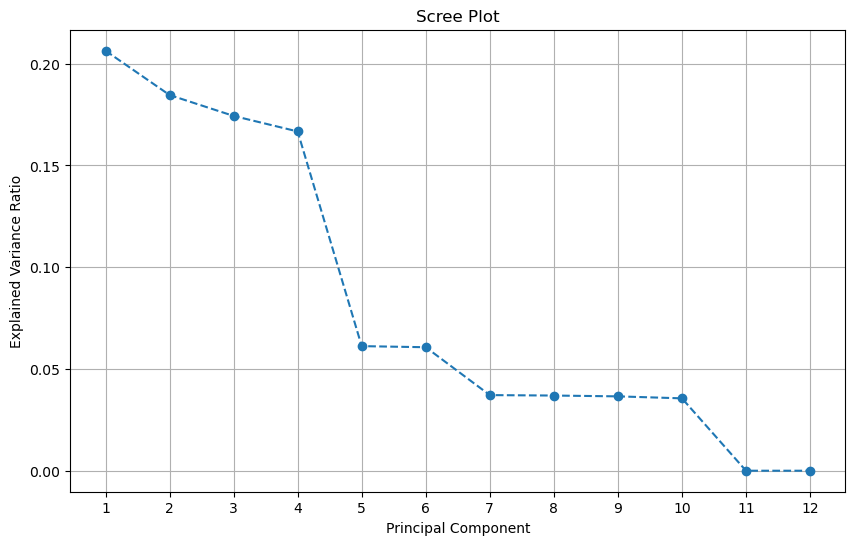

2024/12/21 16:42:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/21 16:42:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLFlow Run for PCA logged with explained variance ratio: 1.0
🏃 View run sassy-snail-147 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/2bf2ed834f454d469ed8ee0a706524f2
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0


In [65]:
from sklearn.decomposition import PCA
import os

# Example data (replace X, y with your dataset)
# X = your_feature_data
# y = your_target_variable

mlflow.sklearn.autolog()


# Step 4: Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Step 5: Create the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)

# Ensure the directory for saving the figure exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Save the figure locally
fig_path = os.path.join(output_dir, "scree_plot.png")
plt.savefig(fig_path)
plt.show()

# Step 6: Log PCA results in MLFlow
with mlflow.start_run():
    # Log the PCA components and explained variance ratio
    mlflow.log_param('PCA_components', len(explained_variance_ratio))
    mlflow.log_metric('explained_variance_ratio', sum(explained_variance_ratio))
    
    # Log the PCA model
    mlflow.sklearn.log_model(pca, 'pca_model')
    
    # Log the scree plot image
    mlflow.log_artifact(fig_path)
    
    print(f"MLFlow Run for PCA logged with explained variance ratio: {sum(explained_variance_ratio)}")


In [66]:
x_pca_components = pd.DataFrame(X_pca)
x_pca_components

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.888598,-0.307434,-0.204524,-0.144942,-0.681655,-0.479859,0.841081,0.057240,-0.161674,-0.146485,-7.240291e-18,2.508127e-16
1,0.030050,-0.183686,-0.730066,1.584324,0.762007,-0.343500,-0.372336,0.695392,-0.309045,-0.190644,4.291285e-16,-2.615813e-16
2,-0.594186,0.843583,-0.468941,0.024345,-0.696552,-0.466896,-0.081873,-0.004004,0.127852,0.891893,1.240311e-16,-2.497362e-16
3,-0.086846,-0.619487,-0.213094,0.586307,-0.067461,0.806442,0.878130,0.043388,-0.178472,-0.157510,-4.908020e-16,-7.572423e-17
4,-0.737486,-1.057390,0.306160,-1.579407,-0.041782,0.835867,-0.090145,-0.069091,0.812497,-0.322582,6.917517e-15,-1.916482e-15
...,...,...,...,...,...,...,...,...,...,...,...,...
7667,0.279483,0.033960,0.480691,0.397712,-0.038366,0.820836,-0.093345,-0.056683,0.823012,-0.328896,-6.140958e-17,-1.242847e-17
7668,0.022411,0.676510,0.843579,-1.083374,-0.052771,0.815404,-0.101914,-0.049321,0.808567,-0.309734,-8.912787e-17,5.284769e-17
7669,0.059337,0.058315,-0.078199,0.140900,-0.078632,0.800408,0.870366,0.050921,-0.185798,-0.148846,5.883338e-17,-4.661895e-17
7670,-0.001328,-2.003357,-2.729763,0.397944,0.696957,-0.330327,0.857700,0.003712,-0.188643,-0.191586,7.920630e-17,-2.684419e-17


#### Hence from the scree plot the elbow is forming at 12, hence first 12 features explain the 95% of the variance and it gives the accuracy of 98.5% with Random Forest Classifier

### Custom Experiment

In [71]:
from sklearn.tree import DecisionTreeClassifier

# Enable autologging for scikit-learn
mlflow.sklearn.autolog()

# Define classifiers to test (added DecisionTreeClassifier)
classifiers = {
    'DecisionTreeClassifier': DecisionTreeClassifier()  # Added DecisionTreeClassifier
}

# Hyperparameter grid for each classifier
param_grids = {
    
    'DecisionTreeClassifier': {
        'classifier__max_depth': [3, 5, 10, None],  # Hyperparameters for DecisionTreeClassifier
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    }
}

# Iterate over each classifier
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name}...")
    
    # Create the pipeline with preprocessing and the classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Get the corresponding parameter grid
    param_grid = param_grids[clf_name]
    
    # Perform GridSearchCV for hyperparameter tuning with 10-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=1)  # Use n_jobs=1 to avoid parallel execution
    
    # Start an MLflow run
    with mlflow.start_run():
        # Fit the model on the entire training set with hyperparameter tuning
        grid_search.fit(X_train, y_train)
        
        # Log the best hyperparameters and score
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric('best_score', grid_search.best_score_)
        
        # Evaluate the model performance on the training data
        y_train_pred = grid_search.predict(X_train)
        print(f"\n{clf_name} - Training Data Classification Report:\n", classification_report(y_train, y_train_pred))
        
        # Log training classification report
        mlflow.log_metric(f'{clf_name}_train_accuracy', grid_search.score(X_train, y_train))
        
        # Evaluate the model performance on the test data
        y_test_pred = grid_search.predict(X_test)
        print(f"\n{clf_name} - Test Data Classification Report:\n", classification_report(y_test, y_test_pred))
        
        # Log test classification report
        mlflow.log_metric(f'{clf_name}_test_accuracy', grid_search.score(X_test, y_test))
        
        # Confusion matrix for the test data
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"\n{clf_name} - Confusion Matrix on Test Data:\n", cm)
        
        # Log confusion matrix image
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
        plt.title(f'{clf_name} - Confusion Matrix')
        cm_filename = f"{clf_name}_confusion_matrix.png"
        plt.savefig(cm_filename)
        plt.close()
        mlflow.log_artifact(cm_filename)
        
        # Cross-validation results: mean and standard deviation
        cv_results = grid_search.cv_results_
        mean_score = np.mean(cv_results['mean_test_score'])
        std_score = np.std(cv_results['mean_test_score'])
        print(f"\n{clf_name} - CV Mean Score: {mean_score:.4f}, CV Std Score: {std_score:.4f}")
        
        # Log CV mean and std score
        mlflow.log_metric(f'{clf_name}_cv_mean_score', mean_score)
        mlflow.log_metric(f'{clf_name}_cv_std_score', std_score)



Training DecisionTreeClassifier...


2024/12/21 16:49:16 INFO mlflow.sklearn.utils: Logging the 5 best runs, 11 runs will be omitted.


🏃 View run sincere-rat-341 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/580ec88fdffb47f29a1ddfffdadcf582
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run treasured-auk-8 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/5834c863c995479eb9b4a9d355147be6
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run languid-lamb-953 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/2f1db94610e745b58981e75cd1a307f4
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run luminous-jay-334 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/f27761d4ac554313870271f0ef68e91c
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run bittersweet-hare-330 at: https:

In [72]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [73]:
mlflow.sklearn.autolog()

# Define classifiers to test
classifiers = {
    'SVC': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'QDA': QuadraticDiscriminantAnalysis()
}

# Hyperparameter grid for each classifier
param_grids = {

    'SVC': {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    'KNeighborsClassifier': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'GaussianNB': {},

    'GradientBoostingClassifier': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 6, 10]
    },
    'AdaBoostClassifier': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1, 1.0]
    },

    'QDA': {}
}


# Iterate over each classifier
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name}...")
    
    # Create the pipeline with preprocessing and the classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Get the corresponding parameter grid
    param_grid = param_grids[clf_name]
    
    # Perform GridSearchCV for hyperparameter tuning with 10-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=1)  # Use n_jobs=1 to avoid parallel execution
    
    # Start an MLflow run
    with mlflow.start_run():
        # Fit the model on the entire training set with hyperparameter tuning
        grid_search.fit(X_train, y_train)
        
        # Log the best hyperparameters and score
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric('best_score', grid_search.best_score_)
        
        # Evaluate the model performance on the training data
        y_train_pred = grid_search.predict(X_train)
        print(f"\n{clf_name} - Training Data Classification Report:\n", classification_report(y_train, y_train_pred))
        
        # Log training classification report
        mlflow.log_metric(f'{clf_name}_train_accuracy', grid_search.score(X_train, y_train))
        
        # Evaluate the model performance on the test data
        y_test_pred = grid_search.predict(X_test)
        print(f"\n{clf_name} - Test Data Classification Report:\n", classification_report(y_test, y_test_pred))
        
        # Log test classification report
        mlflow.log_metric(f'{clf_name}_test_accuracy', grid_search.score(X_test, y_test))
        
        # Confusion matrix for the test data
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"\n{clf_name} - Confusion Matrix on Test Data:\n", cm)
        
        
        # Cross-validation results: mean and standard deviation
        cv_results = grid_search.cv_results_
        mean_score = np.mean(cv_results['mean_test_score'])
        std_score = np.std(cv_results['mean_test_score'])
        print(f"\n{clf_name} - CV Mean Score: {mean_score:.4f}, CV Std Score: {std_score:.4f}")
        
        # Log CV mean and std score
        mlflow.log_metric(f'{clf_name}_cv_mean_score', mean_score)
        mlflow.log_metric(f'{clf_name}_cv_std_score', std_score)



Training SVC...


2024/12/21 16:51:56 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


🏃 View run persistent-stork-313 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/0fe248d15a344bc483b013a8c525a634
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run tasteful-auk-618 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/347e8d0a2cb549e2af535b5ff01ad76a
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run learned-hound-6 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/ccf0515465fb48a6a4c86cf929786379
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run nosy-roo-491 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/85dae5a099c94fbcb0afb36b66cb62e3
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run delicate-stork-851 at: https:/

2024/12/21 16:52:53 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


🏃 View run puzzled-crow-136 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/2540088e4d074f038204a19ec1d91c22
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run unleashed-elk-693 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/5d437c7f107449eab6930015a8cb5571
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run capricious-stag-8 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/26dd097c85e24f9fbe564b896bf79cb0
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run handsome-fox-633 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/f39aacda64344ba6a0857d8a109e242f
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run angry-jay-619 at: https://d

2024/12/21 16:53:47 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run rogue-ape-202 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/5495c73be9594e2ebf52ffd188efd8ff
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0

GaussianNB - Training Data Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5523
           1       0.96      0.89      0.92       614

    accuracy                           0.98      6137
   macro avg       0.97      0.94      0.96      6137
weighted avg       0.98      0.98      0.98      6137


GaussianNB - Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1382
           1       0.99      0.88      0.93       153

    accuracy                           0.99      1535
   macro avg       0.99      0.94      0.96      1535
weighted avg       0.99      0.99      0.99      1535


Gaussian

2024/12/21 17:02:20 INFO mlflow.sklearn.utils: Logging the 5 best runs, 13 runs will be omitted.


🏃 View run secretive-vole-543 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/6fb6ed62f7f0431a830c27990d2a0825
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run gregarious-calf-599 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/7ef125fc80b14ea48ee27d0275d6d2d1
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run treasured-colt-569 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/a8ac8c098e524e64a168b5c732c2af0b
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run marvelous-sponge-505 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/3e748c5f2b9240eda9180416dc6fe1fa
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run youthful-sloth-619

2024/12/21 17:03:53 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


🏃 View run dashing-toad-743 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/16780f1f316e4567b6ad1584597651be
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run vaunted-asp-249 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/1d41d27df2ed40de90279767bdaa726c
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run upset-sheep-123 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/035b303b0f7e48648d424dc04e06f5bd
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run amazing-kite-712 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/dc77bf6a3cb145d6956dd1423ba330bf
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
🏃 View run sincere-snake-760 at: https://d

C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Yaseen\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Yaseen\anaconda3\Li

🏃 View run aged-cat-770 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/b9a7da8200c6451a87b90071adb22083
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0

QDA - Training Data Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      5523
           1       0.73      0.81      0.77       614

    accuracy                           0.95      6137
   macro avg       0.86      0.89      0.87      6137
weighted avg       0.95      0.95      0.95      6137


QDA - Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1382
           1       0.72      0.82      0.76       153

    accuracy                           0.95      1535
   macro avg       0.85      0.89      0.87      1535
weighted avg       0.95      0.95      0.95      1535


QDA - Confusion Matrix 

In [74]:
import mlflow
import mlflow.sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Enable autologging for MLFlow
mlflow.sklearn.autolog()


# Define numerical and categorical columns
numerical_features = ['temperature', 'pressure', 'vibration', 'humidity']  # Replace with your actual numerical features
categorical_features = ['equipment_name', 'location_name']  # Replace with your actual categorical features

# Define the preprocessor pipeline for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler()),  # Standardize the data
    ('minmax', MinMaxScaler())  # Min-Max scaling (if required, can be adjusted)
])


# Define the preprocessor pipeline for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


# Define the classifier (GaussianNB)
clf_name = 'GaussianNB'
clf = GaussianNB()

# Hyperparameter grid for GaussianNB (no hyperparameters for grid search)
param_grids = {
    'GaussianNB': {}
}

# Create the pipeline with preprocessing and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# Get the corresponding parameter grid
param_grid = param_grids[clf_name]

# Perform GridSearchCV for hyperparameter tuning with 10-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=1)  # Use n_jobs=1 to avoid parallel execution

# Start an MLflow run
with mlflow.start_run():
    # Fit the model on the entire training set with hyperparameter tuning
    grid_search.fit(X_train, y_train)
    
    # Log the best hyperparameters and score
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric('best_score', grid_search.best_score_)
    
    # Evaluate the model performance on the training data
    y_train_pred = grid_search.predict(X_train)
    print(f"\n{clf_name} - Training Data Classification Report:\n", classification_report(y_train, y_train_pred))
    
    # Log training classification report
    mlflow.log_metric(f'{clf_name}_train_accuracy', grid_search.score(X_train, y_train))
    
    # Evaluate the model performance on the test data
    y_test_pred = grid_search.predict(X_test)
    print(f"\n{clf_name} - Test Data Classification Report:\n", classification_report(y_test, y_test_pred))
    
    # Log test classification report
    mlflow.log_metric(f'{clf_name}_test_accuracy', grid_search.score(X_test, y_test))
    
    # Confusion matrix for the test data
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"\n{clf_name} - Confusion Matrix on Test Data:\n", cm)
    
    
    # Cross-validation results: mean and standard deviation
    cv_results = grid_search.cv_results_
    mean_score = np.mean(cv_results['mean_test_score'])
    std_score = np.std(cv_results['mean_test_score'])
    print(f"\n{clf_name} - CV Mean Score: {mean_score:.4f}, CV Std Score: {std_score:.4f}")
    
    # Log CV mean and std score
    mlflow.log_metric(f'{clf_name}_cv_mean_score', mean_score)
    mlflow.log_metric(f'{clf_name}_cv_std_score', std_score)


2024/12/21 17:05:25 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run fun-foal-429 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/5130589830754980a61df75d6dbe3b30
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0

GaussianNB - Training Data Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5523
           1       0.96      0.89      0.92       614

    accuracy                           0.98      6137
   macro avg       0.97      0.94      0.96      6137
weighted avg       0.98      0.98      0.98      6137


GaussianNB - Test Data Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1382
           1       0.99      0.88      0.93       153

    accuracy                           0.99      1535
   macro avg       0.99      0.94      0.96      1535
weighted avg       0.99      0.99      0.99      1535


GaussianN

In [78]:
import pickle

# Save the best pipeline model
with open("gaussian_nb_model.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)


In [81]:
print(model.named_steps["preprocessor"])  # Adjust "preprocessor" to the name of your ColumnTransformer in the pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('minmax', MinMaxScaler())]),
                                 ['temperature', 'pressure', 'vibration',
                                  'humidity']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['equipment_name', 'location_name'])])


In [98]:
y_train

3458    0
636     0
4884    0
3962    0
6287    0
       ..
1924    0
548     0
3890    0
1042    1
3274    0
Name: faulty, Length: 6137, dtype: int64

In [99]:
X_train

,equipment_name,location_name,temperature,pressure,vibration,humidity
3458,Turbine,Atlanta,68.596249,29.624662,0.986966,58.204381
636,Pump,Chicago,71.373525,24.384980,1.892085,37.355447
4884,Turbine,Atlanta,74.395012,36.446969,1.571815,67.199845
3962,Turbine,San Francisco,71.915774,28.193738,1.583522,46.086696
6287,Pump,Atlanta,53.660770,24.401336,2.088785,30.704903
...,...,...,...,...,...,...
1924,Pump,Atlanta,70.210038,43.853683,1.371703,51.479689
548,Pump,New York,61.657182,37.560466,1.504645,62.323792
3890,Pump,Chicago,55.612799,32.017794,1.341727,61.901096
1042,Pump,Atlanta,79.852850,65.143210,1.024907,71.990642


In [106]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
import joblib

# Assume this is your data schema
# First column is categorical, second is categorical, rest are numerical
categorical_indices = [0, 1]  # Example: 'Type', 'Location'
numerical_indices = [2, 3, 4, 5]  # Example: other numerical features

# Define the preprocessing pipeline
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),
        ('num', numerical_transformer, numerical_indices),
    ],
    remainder='passthrough'  # Ensure other columns pass through if not specified
)

# Create the final pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])


# Convert to numpy array for consistent processing (optional but recommended)
X_train = np.array(X_train)

# Fit the pipeline
model_pipeline.fit(X_train, y_train)

# Save the pipeline
joblib.dump(model_pipeline, 'gaussian_nb_pipeline.pkl')

# Predict on new input
sample_input = [['Turbine', 'Atlanta', 68.596249, 29.624662, 0.986966, 58.204381]]
sample_input = np.array(sample_input)  # Ensure consistent input format
prediction = model_pipeline.predict(sample_input)

print("Prediction:", prediction)


2024/12/21 17:36:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7402d0febb3849ac885808dad401966e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/21 17:36:34 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


🏃 View run gentle-lamb-515 at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0/runs/7402d0febb3849ac885808dad401966e
🧪 View experiment at: https://dagshub.com/yaseensiddiqui36/my-first-repo.mlflow/#/experiments/0
Prediction: [0]


In [94]:
import joblib
joblib.dump(grid_search.best_estimator_, 'gaussian_nb_pipeline.pkl')

['gaussian_nb_pipeline.pkl']

In [109]:
model_pipeline = joblib.load('gaussian_nb_pipeline.pkl')
sample_input = [['Turbine', 'Atlanta',68.596249, 29.624662, 0.986966, 58.204381]]
prediction = model_pipeline.predict(np.array(sample_input))
prediction

array([0], dtype=int64)

In [85]:
print(sample_input.columns)

RangeIndex(start=0, stop=6, step=1)


In [90]:
X_train

,equipment_name,location_name,temperature,pressure,vibration,humidity
3458,Turbine,Atlanta,68.596249,29.624662,0.986966,58.204381
636,Pump,Chicago,71.373525,24.384980,1.892085,37.355447
4884,Turbine,Atlanta,74.395012,36.446969,1.571815,67.199845
3962,Turbine,San Francisco,71.915774,28.193738,1.583522,46.086696
6287,Pump,Atlanta,53.660770,24.401336,2.088785,30.704903
...,...,...,...,...,...,...
1924,Pump,Atlanta,70.210038,43.853683,1.371703,51.479689
548,Pump,New York,61.657182,37.560466,1.504645,62.323792
3890,Pump,Chicago,55.612799,32.017794,1.341727,61.901096
1042,Pump,Atlanta,79.852850,65.143210,1.024907,71.990642


In [89]:
for i in sample_input.columns:
    print(i)

0
1
2
3
4
5


In [ ]:
import pandas as pd

# Assuming sample_input is a DataFrame, make sure it has the correct columns
sample_input = pd.DataFrame({
    'temperature': [20.5],
    'pressure': [101.2],
    'vibration': [0.02],
    'humidity': [60],
    'equipment_name': ['Pump'],
    'location_name': ['Factory']
})

print(sample_input.columns)  # Check the columns


In [ ]:
# Example of fitting the preprocessor on training data before prediction
preprocessor.fit(X_train)

# Then apply the preprocessor on sample_input for prediction
transformed_input = preprocessor.transform(sample_input)
prediction = model.predict(transformed_input)


In [92]:
import joblib
import numpy as np


sample_data = [
    {"equipment_name": "Turbine", "location_name": "Atlanta", "temperature": 68.596249, "pressure": 29.624662, "vibration": 0.986966, "humidity": 58.204381},
    {"equipment_name": "Pump", "location_name": "Chicago", "temperature": 71.373525, "pressure": 24.384980, "vibration": 1.892085, "humidity": 37.355447},
]

# Process and prepare the data (example preprocessing)
numerical_features = [[d["temperature"], d["pressure"], d["vibration"], d["humidity"]] for d in sample_data]
categorical_features = [[d["equipment_name"], d["location_name"]] for d in sample_data]

# Combine numerical and categorical features
# You must apply the same preprocessing used during training
# Assuming `preprocessor` was used during training, load it if available
try:
    from joblib import load
    preprocessor = load("preprocessor.pkl")  # Preprocessor file if saved
    input_features = preprocessor.transform(numerical_features + categorical_features)
except:
    input_features = np.hstack((numerical_features, categorical_features))  # Fallback for unprocessed data

# Make predictions
try:
    predictions = model.predict(input_features)
    print("Predictions:", predictions)
except Exception as e:
    print(f"Prediction failed: {e}")


Prediction failed: 'numpy.ndarray' object has no attribute 'predict'


In [93]:
# Assuming `preprocessor` is correctly fitted
transformed_input = preprocessor.transform(input_features)
prediction = model.predict(transformed_input)


NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [91]:
import pickle

# Load the saved model
with open("gaussian_nb_model.pkl", "rb") as f:
    model = pickle.load(f)

import pandas as pd


# Ensure input matches expected schema
sample_input = pd.DataFrame([["Pump","New York",100.5, 2.3, 0.7, 45.2 ]])  # Adjust to match your features

prediction = model.predict(sample_input)
print(f"Prediction: {prediction}")


AttributeError: 'numpy.ndarray' object has no attribute 'predict'

In [ ]:
X_train

In [80]:
import joblib

# Save the trained model
model_filename = 'gaussian_nb_model.pkl'
model = grid_search.best_estimator_
joblib.dump(model , model_filename)

print(f"Model saved as {model_filename}")


Model saved as gaussian_nb_model.pkl


In [ ]:
final_model_reloaded = joblib.load('gaussian_nb_model.pk1')

In [ ]:
df1

In [ ]:
import pickle

# Load the model
with open("gaussian_nb_model.pkl", "rb") as f:
    model = pickle.load(f)

# Test prediction
sample_input = [[100.5, 2.3, 0.7, 45.2, "Pump", "New York"]]  # Adjust to match input schema
prediction = model.predict(sample_input)
print(f"Prediction: {prediction}")


In [ ]:
pip install fastapi uvicorn joblib

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the saved model (GaussianNB with preprocessing)
model = joblib.load('gaussian_nb_model.joblib')

app = FastAPI()

# Define the input data schema
class PredictionRequest(BaseModel):
    features: list

# Define the prediction endpoint
@app.post("/predict")
def predict(request: PredictionRequest):
    # Extract the features from the request
    features = np.array(request.features).reshape(1, -1)

    # Make prediction using the trained model
    prediction = model.predict(features)

    return {"prediction": prediction.tolist()}
